In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### EC3D dataset
For the analysis EC3D dataset was used. Here is it's overview:

| Exercise                   | Instruction label | Sub1 | Sub2 | Sub3 | Sub4 | Total |
|-----------------------------------|-------------------|------|------|------|------|-------|
| Squats                       | Correct           | 10   | 10   | 11   | 10   | 41 |
|                              | Feet too wide     | 5    | 8    | 5    | 5    | 23    |
|                              | Knees inward      | 6    | 7    | 5    | 5    | 23    |
|                              | Not low enough    | 5    | 7    | 5    | 4    | 21    |
|                              | Front bent        | 5    | 6    | 6    | 7    | 24    |
| Lunges                       | Correct              | 12   | 11   | 11   | 12   | 46    |
|                              | Not low enough    | 10   | 10   | 10   | 10   | 40    |
|                              | Knee passes toe   | 10   | 10   | 11   | 10   | 41    |
| Planks                       | Correct               | 7    | 8    | 11   | 7    | 33    |
|                              | Arched back       | 5    | 5    | 11   | 9    | 30    |
|                              | Hunch back        | 10   | 10   | 11   | 9    | 40    |


In [2]:
LABELS_COLUMNS = ["exercise", "subject", "label", "rep", "frame"]

In [3]:
dataset = pd.read_pickle("../../data/data_3D.pickle")

poses = dataset["poses"]

labels_df = pd.DataFrame(dataset["labels"], columns=LABELS_COLUMNS)
labels_df["frame"] = np.arange(len(labels_df))
labels_df[LABELS_COLUMNS[2:]] = labels_df[LABELS_COLUMNS[2:]].astype("int")

In [4]:
x = labels_df[labels_df["exercise"] == "Plank"]
for _, person in x[x["label"] == 8].groupby("subject"):
    print(person["rep"].unique())

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10 11]
[ 2  3  4  5  6  7  8  9 10]


### Dataset processing

To prepare data for deep models we need to keep only label and positions in time for each exercise.


In [5]:
def get_rep_frames_from_df(df: pd.DataFrame) -> pd.Grouper:
    groups = df.groupby("subject")

    return [
        rep["frame"].values
        for _, subject_group in groups
        for _, rep in subject_group.groupby("rep")
    ]


def get_df_from_frames(
    df: pd.DataFrame, exercises: np.ndarray, label: str
) -> pd.DataFrame:
    frames = get_rep_frames_from_df(df)
    final_reps_df = pd.DataFrame()
    for rep_num, frames_rep in enumerate(frames, start=1):
        rep_3d_joints = exercises[frames_rep]

        rep_3d_joints_x = rep_3d_joints[:, 0, :].reshape(-1)
        rep_3d_joints_y = rep_3d_joints[:, 1, :].reshape(-1)
        rep_3d_joints_z = rep_3d_joints[:, 2, :].reshape(-1)
        frames_num = len(rep_3d_joints_x) // 25
        final_rep = np.array(
            [
                np.full_like(rep_3d_joints_x, rep_num, dtype=int),
                rep_3d_joints_x,
                rep_3d_joints_y,
                rep_3d_joints_z,
                np.repeat(np.arange(frames_num, dtype=int), 25),
                np.full_like(rep_3d_joints_x, label, dtype="<U15"),
            ]
        ).T
        final_reps_df = pd.concat(
            [
                final_reps_df,
                pd.DataFrame(
                    final_rep, columns=["rep", "x", "y", "z", "frame", "label"]
                ),
            ],
            axis=0,
        )

    final_reps_df["rep"] = final_reps_df["rep"].astype("int")
    final_reps_df["frame"] = final_reps_df["frame"].astype("int")

    return final_reps_df

### Squat

In [6]:
LABELS_COLUMNS = ["exercise", "subject", "label", "rep", "frame"]

SQUAT_LABELS = {
    1: "correct",
    2: "feet_too_wide",
    3: "knees_inwards",
    4: "not_low_enough",
    5: "front_bend",
}
LUNGES_LABELS = {
    1: "correct",
    4: "not_low_enough",
    6: "knee_passes_toe",
}
PLANK_LABELS = {
    1: "correct",
    7: "arched_back",
    8: "hunched_back",
}

In [7]:
squat_df = labels_df[labels_df["exercise"] == "SQUAT"]
lunges_df = labels_df[labels_df["exercise"] == "Lunges"]
planks_df = labels_df[labels_df["exercise"] == "Plank"]

In [8]:
squat_df

,exercise,subject,label,rep,frame
0,SQUAT,Hugues,1,1,0
1,SQUAT,Hugues,1,1,1
2,SQUAT,Hugues,1,1,2
3,SQUAT,Hugues,1,1,3
4,SQUAT,Hugues,1,1,4
...,...,...,...,...,...
11104,SQUAT,Isinsu,5,6,11104
11105,SQUAT,Isinsu,5,6,11105
11106,SQUAT,Isinsu,5,6,11106
11107,SQUAT,Isinsu,5,6,11107


In [9]:
import os

output_dir = "../../data"

for df, labels in [
    (squat_df, SQUAT_LABELS),
    (lunges_df, LUNGES_LABELS),
    (planks_df, PLANK_LABELS),
]:
    exercise_dfs = []
    for label, label_name in labels.items():
        exercise_dfs.append(
            get_df_from_frames(df[df["label"] == label], poses, label_name)
        )

    pd.concat(exercise_dfs).to_csv(
        os.path.join(output_dir, f"{df['exercise'].values[0].lower()}.csv"),
        index=False,
    )

### Visualization 

In [10]:
openpose_connections = [
    (0, 1),
    (1, 2),
    (1, 5),
    (1, 8),
    (2, 3),
    (3, 4),
    (5, 6),
    (6, 7),
    (8, 9),
    (9, 10),
    (10, 11),
    (8, 12),
    (12, 13),
    (13, 14),
    (0, 15),
    (0, 16),
    (15, 17),
    (16, 18),
    (17, 18),
    (11, 24),
    (11, 22),
    (22, 23),
    (14, 21),
    (14, 19),
    (19, 20),
]
correct_squat_df = pd.read_csv("../../data/joints/squat.csv")
correct_squat_1_rep_df = correct_squat_df[
    (correct_squat_df["rep"] == 20) & (correct_squat_df["label"] == "correct")
]

In [11]:
correct_squat_1_rep_df

,rep,frame,x,y,z,label
38775,20,0,0.003074,5.019647e-02,0.272710,correct
38776,20,0,0.008556,1.734723e-18,0.195177,correct
38777,20,0,-0.052085,-1.030516e-03,0.194393,correct
38778,20,0,-0.104801,8.110796e-02,0.162209,correct
38779,20,0,-0.117064,1.757932e-01,0.178103,correct
...,...,...,...,...,...,...
41045,20,90,0.092047,6.484777e-02,-0.291350,correct
41046,20,90,0.058113,7.005692e-03,-0.303498,correct
41047,20,90,-0.100143,7.591545e-02,-0.286061,correct
41048,20,90,-0.107261,6.480755e-02,-0.284707,correct


In [12]:
rep_joint = pd.DataFrame(
    [
        joints.reset_index().loc[1]
        for _, joints in correct_squat_1_rep_df.groupby("frame")
    ]
)

In [14]:
joint_tensor = torch.tensor(rep_joint[["x", "y", "z"]].values)
dct_2d(joint_tensor).shape

torch.Size([91, 3])

In [169]:
from scipy.fft import dct, idct

dct(rep_joint["x"].values)

array([ 1.77235516e+00,  1.93550402e-02, -6.10309717e-01,  2.93148125e-02,
        1.96669056e-01,  6.70499184e-02,  1.50116892e-01,  8.90138860e-02,
       -8.60724461e-02, -1.24325112e-01,  1.72719675e-01, -3.92814242e-02,
       -5.44771157e-02,  6.29004751e-02,  6.76117788e-03,  4.90850667e-02,
       -1.61457387e-02, -2.16507942e-02,  2.14643252e-02,  6.78777702e-03,
       -2.23593247e-02, -7.26066625e-03, -1.92074552e-02,  1.41491572e-02,
        1.34144935e-02, -1.87674712e-02, -4.47017483e-03,  1.40342391e-02,
        6.02934201e-03, -4.89777236e-03,  4.58763155e-03,  4.26093110e-03,
        1.33727273e-03, -2.62512880e-03, -1.42968126e-03,  5.12466491e-04,
       -1.12165452e-03,  5.34660408e-06, -1.56824185e-04, -5.95800130e-04,
        4.21926858e-04,  2.50334904e-04,  9.96976746e-05, -3.84103136e-05,
       -3.88044299e-05, -4.61425340e-04, -4.52134348e-04,  8.51114156e-05,
        8.26933754e-04, -4.98834204e-04, -1.71542371e-04,  5.17271783e-04,
        2.74313630e-04,  

In [55]:
input = rep_joint[["x", "y", "z"]].values

In [142]:
input.shape

(91, 3)

In [161]:
from scipy.fftpack import dct, idct


def get_dct_features(input) -> np.ndarray:
    compressed_dct = dct(input, norm="ortho")[:25]
    x_dct = np.zeros(91, dtype=float)

    x_dct[:25] = compressed_dct
    x_idct = idct(x_dct, norm="ortho")
    return x_idct


out = get_dct_features(input[:, 0])

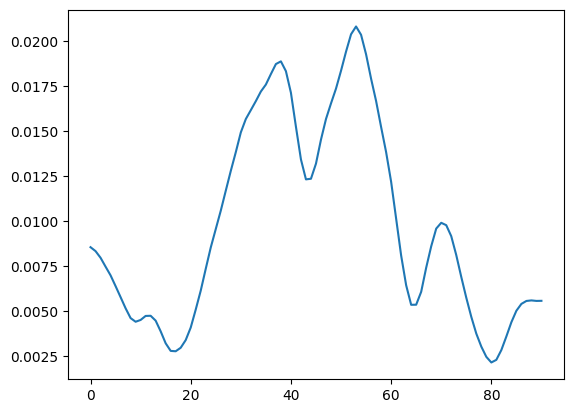

In [162]:
plt.plot(input[:, 0], label="x")

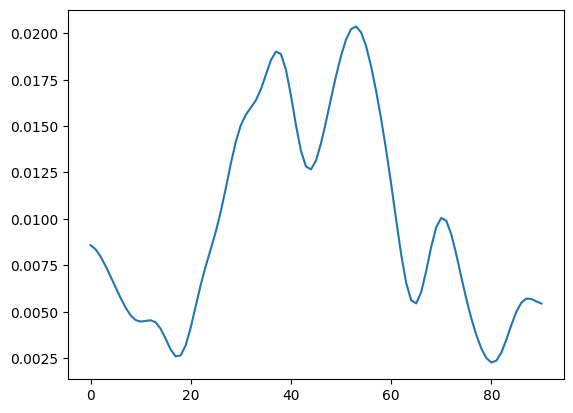

In [164]:
plt.plot(out, label="x")

In [17]:
rep_joint[["x", "y", "z"]].values

array([[ 8.55558023e-03,  1.73472348e-18,  1.95176619e-01],
       [ 8.33807697e-03,  1.73472348e-18,  1.95176619e-01],
       [ 7.96943412e-03,  3.46944695e-18,  1.95176619e-01],
       [ 7.47586986e-03,  1.73472348e-18,  1.95176619e-01],
       [ 6.99260640e-03, -3.46944695e-18,  1.95176619e-01],
       [ 6.39389559e-03,  1.04083409e-17,  1.95176619e-01],
       [ 5.78168277e-03,  3.46944695e-18,  1.95176619e-01],
       [ 5.16347164e-03,  1.56125113e-17,  1.95176619e-01],
       [ 4.61710550e-03,  0.00000000e+00,  1.95176619e-01],
       [ 4.41522247e-03,  3.46944695e-18,  1.95176619e-01],
       [ 4.51454895e-03,  5.20417043e-18,  1.95176619e-01],
       [ 4.73741445e-03, -1.90819582e-17,  1.95176619e-01],
       [ 4.74686611e-03, -3.46944695e-18,  1.95176619e-01],
       [ 4.47635690e-03,  1.38777878e-17,  1.95176619e-01],
       [ 3.88414431e-03,  8.67361738e-18,  1.95176619e-01],
       [ 3.21807842e-03, -9.54097912e-18,  1.95176619e-01],
       [ 2.79608403e-03, -2.60208521e-17

In [18]:
print(out)

[[ 4.11639534e-01 -4.77258832e-01  2.91073106e-01]
 [ 3.20173068e-01 -3.70849809e-01  2.26396548e-01]
 [ 1.74278365e-01 -2.00897583e-01  1.23233414e-01]
 [ 3.01866814e-02 -3.25857079e-02  2.13452071e-02]
 [-6.30144625e-02  7.69558652e-02 -4.45579538e-02]
 [-8.46551373e-02  1.03283774e-01 -5.98602216e-02]
 [-4.83110823e-02  6.15710879e-02 -3.41610939e-02]
 [ 9.59097579e-03 -6.29727167e-03  6.78184402e-03]
 [ 5.10424214e-02 -5.61262374e-02  3.60924423e-02]
 [ 5.56309181e-02 -6.36177099e-02  3.93369994e-02]
 [ 2.78425634e-02 -3.30958640e-02  1.96876654e-02]
 [-9.95509954e-03  1.01985512e-02 -7.03931839e-03]
 [-3.32334408e-02  3.79673457e-02 -2.34995914e-02]
 [-2.99041600e-02  3.56943070e-02 -2.11454344e-02]
 [-5.69273718e-03  9.12815160e-03 -4.02537306e-03]
 [ 2.16635956e-02 -2.19797833e-02  1.53184754e-02]
 [ 3.46594257e-02 -3.76500461e-02  2.45079149e-02]
 [ 2.66994944e-02 -2.99114515e-02  1.88793936e-02]
 [ 4.96409036e-03 -6.33010300e-03  3.51014196e-03]
 [-1.54728963e-02  1.63785375e-

In [19]:
X_LIM = (-1, 1)
Y_LIM = (-1, 1)
Z_LIM = (-1, 1)

ELEV = 0
AZIM = 0

KeyboardInterrupt: 

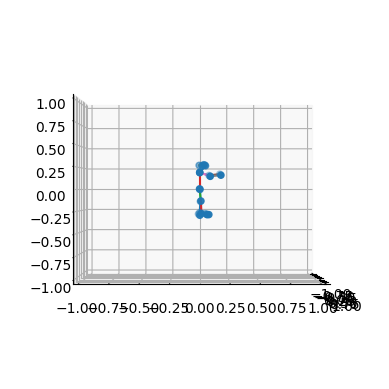

In [20]:
import matplotlib.animation as animation
from IPython.display import HTML


def get_3D_animation(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    def update(i):
        ax.clear()
        ax.set_xlim3d(*X_LIM)
        ax.set_ylim3d(*Y_LIM)
        ax.set_zlim3d(*Z_LIM)
        ax.view_init(elev=ELEV, azim=AZIM)

        frame_data = data[data["frame"] == i]
        ax.scatter3D(frame_data["x"], frame_data["y"], frame_data["z"])
        frame_data = frame_data.reset_index()

        for start, stop in openpose_connections:
            ax.plot(
                xs=[frame_data.loc[start]["x"], frame_data.loc[stop]["x"]],
                ys=[frame_data.loc[start]["y"], frame_data.loc[stop]["y"]],
                zs=[frame_data.loc[start]["z"], frame_data.loc[stop]["z"]],
            )

    return animation.FuncAnimation(
        fig, update, frames=pd.unique(data["frame"]), interval=120
    )


ani = get_3D_animation(correct_squat_1_rep_df)
HTML(ani.to_jshtml())